<a href="https://colab.research.google.com/github/LoPA607/IE643/blob/main/IE643_2025_VGG16_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing the libraries-**

In [1]:
import torch
from torchvision import transforms
import torchvision.datasets as datasets
from torch import nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import random
import requests
from PIL import Image
from io import BytesIO
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

In [2]:
def set_random_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

set_random_seed(42)

##Downloading the data-

- About dataset : https://www.cs.toronto.edu/~kriz/cifar.html

In [3]:
cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),transforms.Resize((128,128))]))
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),transforms.Resize((128,128))]))

100%|██████████| 170M/170M [00:03<00:00, 44.0MB/s]


##The CIFAR-10 dataset
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.


In [4]:
print(len(cifar_trainset))
print(len(cifar_testset))

50000
10000


In [5]:
classes = cifar_trainset.classes
print('Number of Classes:', len(classes))
print('Class Names :\n', classes)

Number of Classes: 10
Class Names :
 ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [6]:
#shape of the image tensor
img, label = cifar_trainset[64]
img_shape = img.shape
img_shape

torch.Size([3, 128, 128])

In [7]:
print("Max & Min Pixel Values:", "Max:", torch.max(img), "Min:", torch.min(img))
print("Pixel Values for all Channels:\n", img[:, :, :])

Max & Min Pixel Values: Max: tensor(2.3530) Min: tensor(-2.1405)
Pixel Values for all Channels:
 tensor([[[-1.1690, -1.1690, -1.1642,  ..., -0.4373, -0.4518, -0.4518],
         [-1.1690, -1.1690, -1.1642,  ..., -0.4373, -0.4518, -0.4518],
         [-1.1690, -1.1690, -1.1648,  ..., -0.3694, -0.3791, -0.3791],
         ...,
         [-0.5996, -0.5996, -0.5836,  ..., -0.8110, -0.7983, -0.7983],
         [-0.5875, -0.5875, -0.5705,  ..., -0.8128, -0.8007, -0.8007],
         [-0.5875, -0.5875, -0.5705,  ..., -0.8128, -0.8007, -0.8007]],

        [[-1.8479, -1.8479, -1.8405,  ..., -0.8105, -0.8252, -0.8252],
         [-1.8479, -1.8479, -1.8405,  ..., -0.8105, -0.8252, -0.8252],
         [-1.8479, -1.8479, -1.8412,  ..., -0.7536, -0.7638, -0.7638],
         ...,
         [-0.7785, -0.7785, -0.7644,  ..., -0.8855, -0.8646, -0.8646],
         [-0.7662, -0.7662, -0.7515,  ..., -0.9039, -0.8842, -0.8842],
         [-0.7662, -0.7662, -0.7515,  ..., -0.9039, -0.8842, -0.8842]],

        [[-1.6556, 

##Splitting the data into test, train and validation dataset-

In [8]:
cifar_trainset, cifar_valset = torch.utils.data.random_split(cifar_trainset, [int(0.8 * len(cifar_trainset)), int(0.2 * len(cifar_trainset))])

In [9]:
print("no of samples in train data",len(cifar_trainset))
print("no of samples in validation data",len(cifar_valset))
print("no of samples in test data",len(cifar_testset))

no of samples in train data 40000
no of samples in validation data 10000
no of samples in test data 10000


**Shuffling and creating batches of data-**

In [10]:
train_dataloader = torch.utils.data.DataLoader(cifar_trainset, batch_size=256, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(cifar_valset, batch_size=256, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(cifar_testset, batch_size=256, shuffle=False)

Batch Calculation Explanation:

The calculated number of batches for each dataset, based on the **batch size of 256** and the PyTorch `DataLoader`'s default behavior, which is **`drop_last=False`**.

* **`drop_last=False`** (The Default): Ensures **all** samples are used, meaning the last batch, even if incomplete is included. This is why the result is always rounded **up** (the ceiling function).


The formula used is the **ceiling function** (rounding up to the nearest whole number):

$$\text{Total Batches} = \lceil \frac{\text{Dataset Size}}{\text{Batch Size}} \rceil$$


1. Training Dataset (40,000 Samples)

| Calculation | Result | Interpretation |
| :---: | :---: | :--- |
| **40,000 / 256** | 156.25 | 156 full batches of size 256, plus a remainder. |
| **Total Batches** | **157** | **156 full batches** + **1 partial batch** (size 64). |

---

2. Validation Dataset (10,000 Samples)

| Calculation | Result | Interpretation |
| :---: | :---: | :--- |
| **10,000 / 256** | 39.0625 | 39 full batches of size 256, plus a remainder. |
| **Total Batches** | **40** | **39 full batches** + **1 partial batch** (size 64). |

---

3. Testing Dataset (10,000 Samples)

| Calculation | Result | Interpretation |
| :---: | :---: | :--- |
| **10,000 / 256** | 39.0625 | 39 full batches of size 256, plus a remainder. |
| **Total Batches** | **40** | **39 full batches** + **1 partial batch** (size 64). |


In [11]:
print("No. of batches in Training dataset : ", len(train_dataloader))
print("No. of batches in Validation dataset : ", len(val_dataloader))
print("No. of batches in Testing dataset : ", len(test_dataloader))


No. of batches in Training dataset :  157
No. of batches in Validation dataset :  40
No. of batches in Testing dataset :  40


**Visualising the data-**

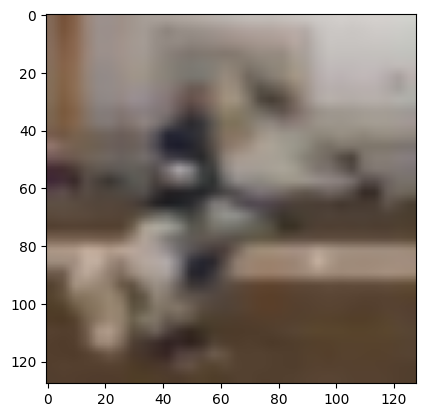

Label as Number: 7
Label as Name: horse


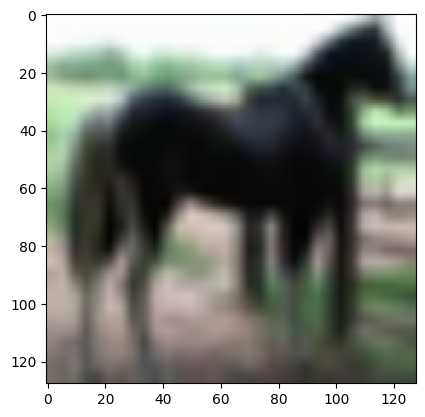

Label as Number: 7
Label as Name: horse


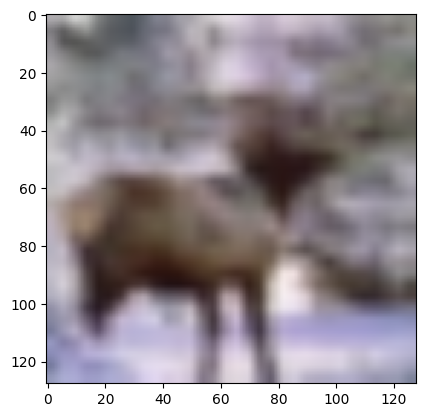

Label as Number: 4
Label as Name: deer


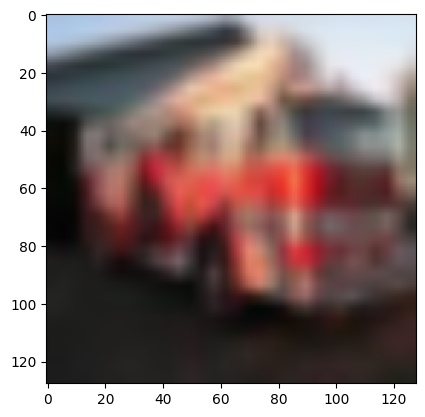

Label as Number: 9
Label as Name: truck


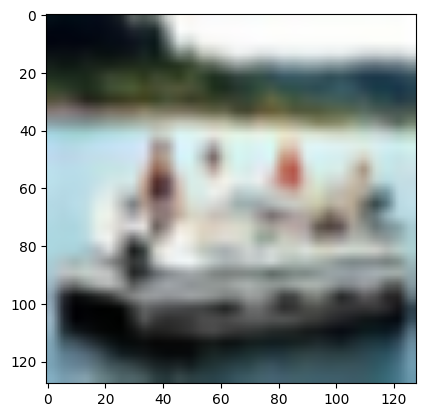

Label as Number: 8
Label as Name: ship


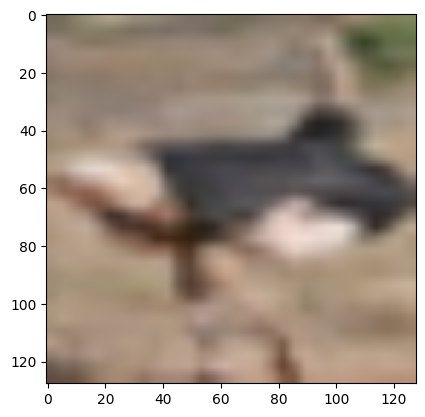

Label as Number: 2
Label as Name: bird


In [12]:
for i in range(6):
  img, label = cifar_trainset[ i +64]
  img[0] = img[0] * 0.2023 + 0.4914
  img[1] = img[1] * 0.1994 + 0.4822
  img[2] = img[2] * 0.2010 + 0.4465
  plt.imshow(img.permute((1,2,0)))
  plt.show()
  print('Label as Number:', label)
  print('Label as Name:', classes[label])

Shape of an Image (Batch Size, RGB, Pixels): torch.Size([256, 3, 128, 128])


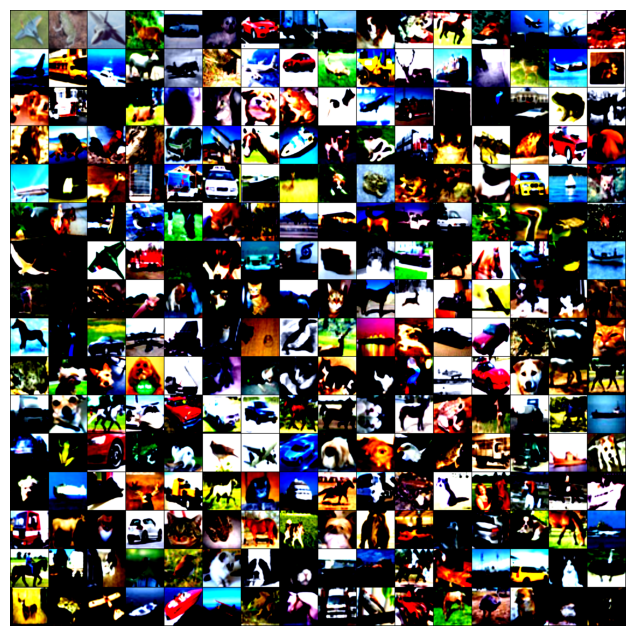

In [13]:
#Displaying the images in train loader
for images, _ in train_dataloader:
    images[0] = images[0] * 0.2023 + 0.4914
    images[1] = images[1] * 0.1994 + 0.4822
    images[2] = images[2] * 0.2010 + 0.4465
    print('Shape of an Image (Batch Size, RGB, Pixels):', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1,2,0))) # we need permute here because matplotlib wants to have the channels as the last dimension
    break

##**VGG-16 Model**

VGG-16 Architecture:


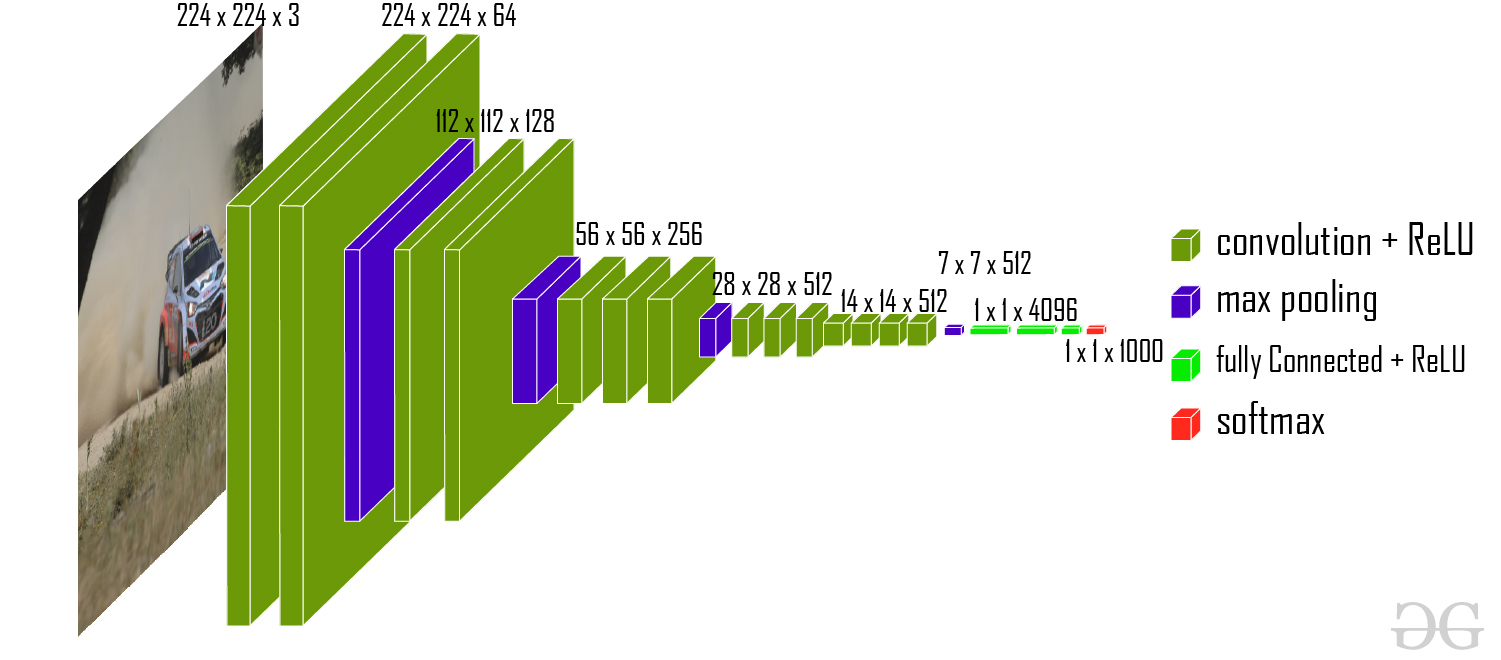

In [14]:
image_url = 'https://media.geeksforgeeks.org/wp-content/uploads/20200219152207/new41.jpg'

# Download the image
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))

# Display the image
print("VGG-16 Architecture:")
display(img)

In [18]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        #self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        #self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        #self.conv7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.conv8 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        #self.conv9 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.conv11 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        #self.conv12 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        #self.conv13 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc14 = nn.Linear(8192, 2024)
        self.fc15 = nn.Linear(2024, 512)
        self.fc16 = nn.Linear(512, 10)

    def forward(self, x):
        # Input shape: [256, 3, 128, 128]

        x = F.relu(self.conv1(x)) # Output shape: [256, 64, 128, 128]
        #x = F.relu(self.conv2(x))
        x = self.maxpool(x)       # Output shape: [256, 64, 64, 64]
        x = F.relu(self.conv3(x)) # Output shape: [256, 128, 64, 64]
        #x = F.relu(self.conv4(x))
        x = self.maxpool(x)       # Output shape: [256, 128, 32, 32]
        x = F.relu(self.conv5(x)) # Output shape: [256, 256, 32, 32]
        x = F.relu(self.conv6(x)) # Output shape: [256, 256, 32, 32]
        #x = F.relu(self.conv7(x))
        x = self.maxpool(x)       # Output shape: [256, 256, 16, 16]
        x = F.relu(self.conv8(x)) # Output shape: [256, 512, 16, 16]
        #x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))# Output shape: [256, 512, 16, 16]
        x = self.maxpool(x)       # Output shape: [256, 512, 8, 8]
        x = F.relu(self.conv11(x))# Output shape: [256, 512, 8, 8]
        #x = F.relu(self.conv12(x))
        #x = F.relu(self.conv13(x))
        x = self.maxpool(x)       # Output shape: [256, 512, 4, 4]
        x = x.reshape(x.shape[0], -1) # Output shape: [256, 8192]
        x = F.relu(self.fc14(x))      # Output shape: [256, 2024]
        x = F.dropout(x, 0.5) #dropout was included to combat overfitting
        x = F.relu(self.fc15(x))      # Output shape: [256, 512]
        x = F.dropout(x, 0.5)
        x = self.fc16(x)   # Output shape: [256, 10]
        return x

#Reason for commenting out some layers in the model:
As we can see the model is very deep. Hence every image in dataset passed through the network will pass through several convolution operations. The resultant convolution feature map after so many convolution operations contains discriminative features so that the image can be predicted correctly.

However maintaining all layers leads to memory overflow and hence some layers are commented.

One solution can be to resize the input to an appropriate size so that some layers are avoided.

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [20]:
model=VGG16()
model=model.cuda()


In [22]:
from torchsummary import summary

summary(model, input_size=(3, 128, 128), batch_size = 256)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [256, 64, 128, 128]           1,792
         MaxPool2d-2          [256, 64, 64, 64]               0
            Conv2d-3         [256, 128, 64, 64]          73,856
         MaxPool2d-4         [256, 128, 32, 32]               0
            Conv2d-5         [256, 256, 32, 32]         295,168
            Conv2d-6         [256, 256, 32, 32]         590,080
         MaxPool2d-7         [256, 256, 16, 16]               0
            Conv2d-8         [256, 512, 16, 16]       1,180,160
            Conv2d-9         [256, 512, 16, 16]       2,359,808
        MaxPool2d-10           [256, 512, 8, 8]               0
           Conv2d-11           [256, 512, 8, 8]       2,359,808
        MaxPool2d-12           [256, 512, 4, 4]               0
           Linear-13                [256, 2024]      16,582,632
           Linear-14                 [2

In [23]:
# Print model's state_dict
model = model.to(device)

print("Model's state_dict:")

for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
conv1.weight 	 torch.Size([64, 3, 3, 3])
conv1.bias 	 torch.Size([64])
conv3.weight 	 torch.Size([128, 64, 3, 3])
conv3.bias 	 torch.Size([128])
conv5.weight 	 torch.Size([256, 128, 3, 3])
conv5.bias 	 torch.Size([256])
conv6.weight 	 torch.Size([256, 256, 3, 3])
conv6.bias 	 torch.Size([256])
conv8.weight 	 torch.Size([512, 256, 3, 3])
conv8.bias 	 torch.Size([512])
conv10.weight 	 torch.Size([512, 512, 3, 3])
conv10.bias 	 torch.Size([512])
conv11.weight 	 torch.Size([512, 512, 3, 3])
conv11.bias 	 torch.Size([512])
fc14.weight 	 torch.Size([2024, 8192])
fc14.bias 	 torch.Size([2024])
fc15.weight 	 torch.Size([512, 2024])
fc15.bias 	 torch.Size([512])
fc16.weight 	 torch.Size([10, 512])
fc16.bias 	 torch.Size([10])


#  Visualizing Filters of the First and Last Convolutional Layers

In [24]:
first_conv_weights = model.conv1.weight.data.cpu().numpy()
first_conv_weights.shape , first_conv_weights[0]

((64, 3, 3, 3),
 array([[[ 0.00946489,  0.06664141,  0.0399684 ],
         [-0.06705819,  0.15602696,  0.07569251],
         [ 0.07806296, -0.12012806, -0.09894515]],
 
        [[ 0.05079736,  0.17011343,  0.06427199],
         [ 0.11092398, -0.00330067,  0.15749794],
         [-0.12991686,  0.18545005,  0.05870963]],
 
        [[-0.10723839,  0.18643433,  0.04025836],
         [ 0.09941268,  0.16857368, -0.11691519],
         [-0.1351591 ,  0.13608548, -0.04028972]]], dtype=float32))

In [25]:
first_conv_weights[15]

array([[[ 0.06434286, -0.03557931,  0.12619631],
        [-0.01340813,  0.09362523,  0.09662527],
        [-0.18126236, -0.01423048,  0.10262203]],

       [[-0.05195606, -0.03136306,  0.09982535],
        [-0.00231485, -0.10457117,  0.1392891 ],
        [ 0.09996599,  0.03158079, -0.13216063]],

       [[-0.13969932, -0.02506559,  0.01061388],
        [ 0.1535662 ,  0.02173154, -0.00165142],
        [ 0.05425791, -0.17029169, -0.00906223]]], dtype=float32)

In [26]:
last_conv_weights = model.conv11.weight.data.cpu().numpy()
last_conv_weights.shape

(512, 512, 3, 3)

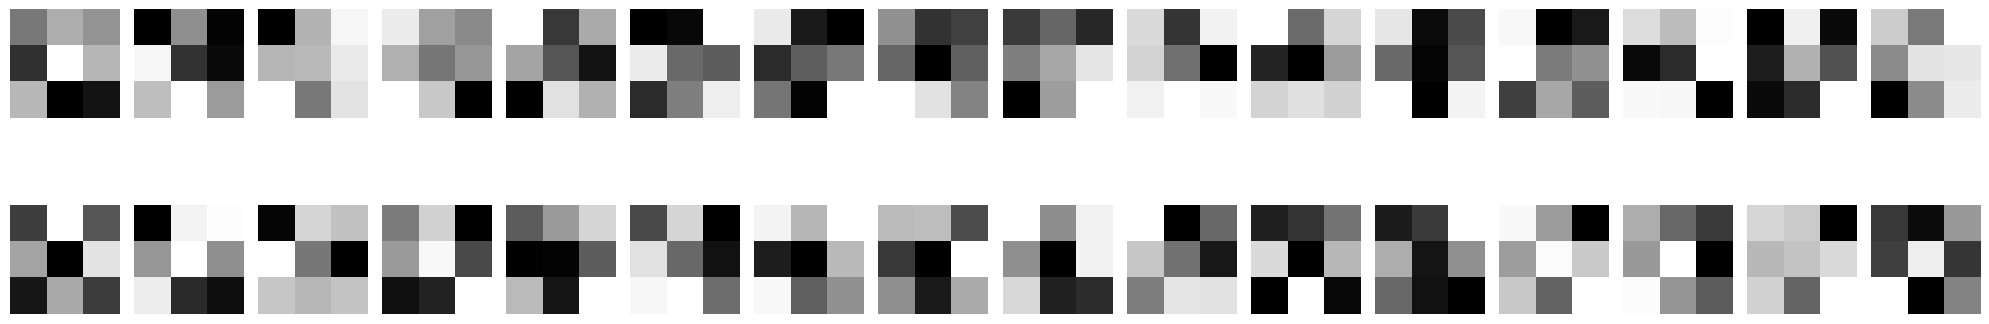

In [28]:
set_random_seed(42)
def visualize_filters(model):
    first_conv_weights = model.conv1.weight.data.cpu().numpy()  # shape: (64, 3, 3, 3)
    last_conv_weights = model.conv11.weight.data.cpu().numpy()  # shape: (512, 512, 3, 3)

    first_conv_weights = (first_conv_weights - first_conv_weights.min()) / (first_conv_weights.max() - first_conv_weights.min())

    last_conv_weights = (last_conv_weights - last_conv_weights.min()) / (last_conv_weights.max() - last_conv_weights.min())

    # Set up the figure
    fig, axes = plt.subplots(2, 16, figsize=(20, 5))

    for i in range(16):
        axes[0, i].imshow(first_conv_weights[i, 0], cmap='gray')
        axes[0, i].axis('off')
    axes[0, 0].set_ylabel('First Layer Filters')

    for i in range(16):
        axes[1, i].imshow(last_conv_weights[i, 0], cmap='gray')
        axes[1, i].axis('off')
    axes[1, 0].set_ylabel('Last Layer Filters')

    plt.tight_layout()
    plt.show()

visualize_filters(model)


$\Large\textbf{Visualizing the Convolution Feature Maps Before Training}$

Registered activation hooks for first and last convolutional layers (conv1, conv11)
Visualizing feature maps for Image 13 in layer 'conv1'


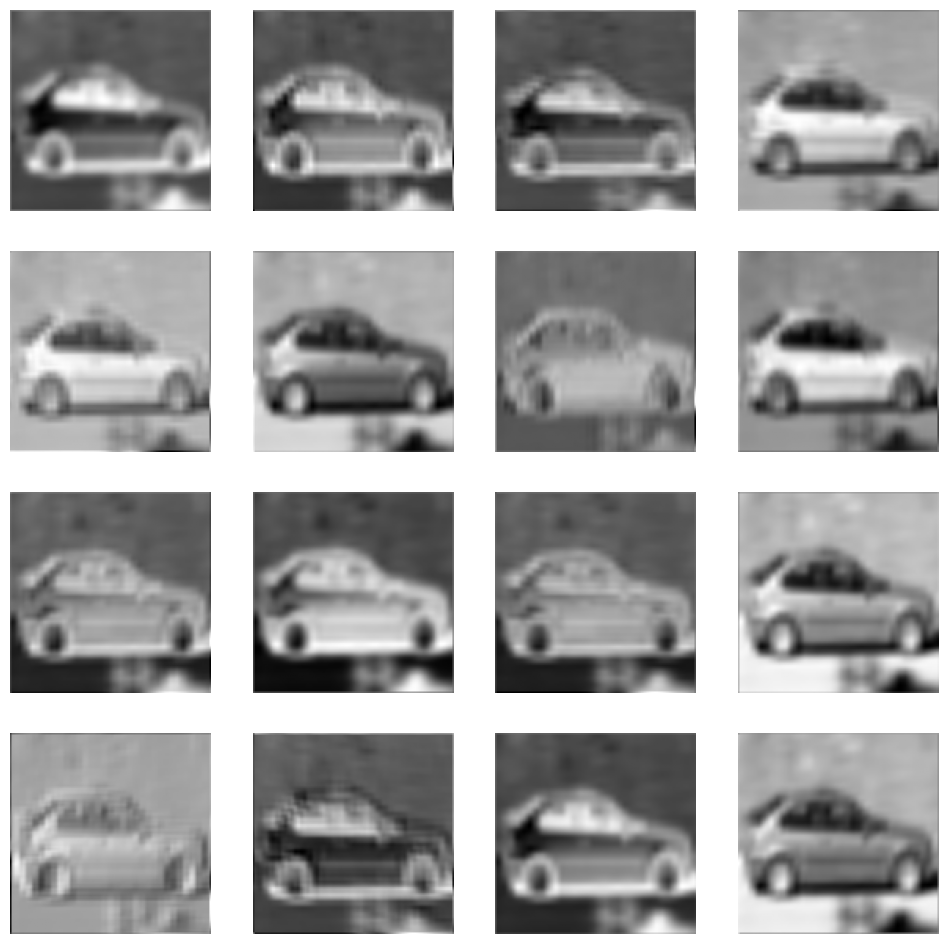

Visualizing feature maps for Image 13 in layer 'conv11'


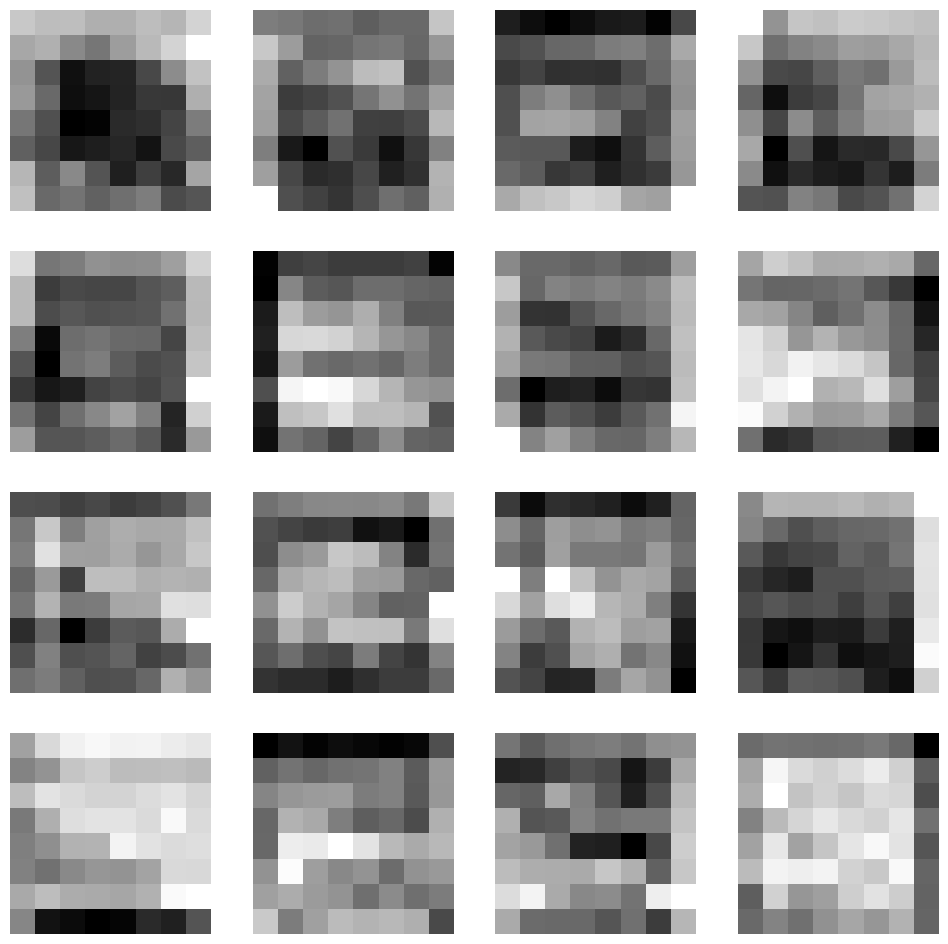

In [29]:
set_random_seed(42)
# Dictionary to store activations for different layers
activation = {}

# Hook function to store activations
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Register hooks for the first and last convolutional layers only
model.conv1.register_forward_hook(get_activation('conv1'))
model.conv11.register_forward_hook(get_activation('conv11'))

print("Registered activation hooks for first and last convolutional layers (conv1, conv11)")

# Visualize the feature maps of a specific layer
def visualize_feature_maps(activation, layer_name, image_idx, num_feature_maps=16):
    feature_maps = activation[layer_name].cpu().numpy()  # (batch_size, num_filters, height, width)
    batch_size, num_filters, height, width = feature_maps.shape

    # Randomly select 16 feature maps to visualize
    selected_filters = random.sample(range(num_filters), min(num_feature_maps, num_filters))

    # Set the layout for visualizing feature maps
    num_cols = 4
    num_rows = 4

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))
    for i, filter_idx in enumerate(selected_filters):
        feature_map = feature_maps[image_idx, filter_idx, :, :]
        row, col = divmod(i, num_cols)
        axes[row, col].imshow(feature_map, cmap='gray')
        axes[row, col].axis('off')

    plt.show()

# Example for loading a batch and visualizing feature maps
for images, _ in train_dataloader:
    # Forward pass to generate feature maps
    images = images.to(device)
    output = model(images)


    image_idx = 12  # For image 13

    print(f"Visualizing feature maps for Image {image_idx + 1} in layer 'conv1'")
    visualize_feature_maps(activation, 'conv1', image_idx=image_idx)

    print(f"Visualizing feature maps for Image {image_idx + 1} in layer 'conv11'")
    visualize_feature_maps(activation, 'conv11', image_idx=image_idx)

    break


In [30]:
criterion = nn.CrossEntropyLoss()# defining the loss
optimizer = optim.SGD(model.parameters(), lr=0.1,weight_decay=0.001)#defining the optimizer
num_epochs=100

## **Training-**

In [31]:
#for printing the results in tabular format
def TabularFormat(epochs,train_cost,train_acc,eval_cost,eval_acc):
  ep = []
  for i in range(1,epochs+1):
    ep.append(i)
  return pd.DataFrame(list(zip(ep,train_cost,train_acc,eval_cost,eval_acc)),columns = ['Epoch Value','Training Loss','Training Accuracy','Validation loss','Validation Accuracy'])

In [ ]:
num_epochs = 100
train_loss = list()
val_loss = list()
train_accuracy = list()
val_accuracy = list()
best_val_loss = 1000
total_train = 0
correct_train = 0
total_val = 0
correct_val = 0
count = 0
from tqdm import tqdm
for epoch in range(num_epochs):
    total_train_loss = 0
    total_val_loss = 0
    total_train = 0
    correct_train = 0
    model.train()
    total_p = 0
    # training
    for itr, (image, label) in tqdm(enumerate(train_dataloader)):

        if (torch.cuda.is_available()):
            image = image.cuda()
            label = label.cuda()

        optimizer.zero_grad()

        pred = model(image)
        #print(label.shape, pred.shape)
        loss = criterion(pred, label)
        total_train_loss += loss.item()
        #ADDED HERE
        predicted = torch.argmax(pred, 1)
        total_train += label.size(0)
        #print(predicted, label)
        correct_train += (predicted == label).sum().item()
        #print("correct train = ",correct_train)

        loss.backward()
        optimizer.step()
        # print(itr+1, "Train Batch complete")
    accuracy_train = (100 * correct_train) / total_train
    #print(total_train)
    train_accuracy.append(accuracy_train)
    total_train_loss = total_train_loss / (itr + 1)
    train_loss.append(total_train_loss)


    # validation
    model.eval()
    total_val = 0
    correct_val = 0
    for itr, (image, label) in enumerate(val_dataloader):

        if (torch.cuda.is_available()):
            image = image.cuda()
            label = label.cuda()

        pred = model(image)

        loss = criterion(pred, label)
        total_val_loss += loss.item()

        predicted = torch.argmax(pred,dim = 1)
        total_val += label.size(0)
        correct_val += (predicted == label).sum().item()
        # print("correct test = ",correct_val)
        # print(itr+1, "Test Batch complete")



    accuracy = (100 * correct_val) / total_val
    val_accuracy.append(accuracy)

    total_val_loss = total_val_loss / (itr + 1)
    val_loss.append(total_val_loss)

    print('\nEpoch: {}/{}, Train Loss: {:.8f},Train Accuracy: {:.8f}, Val Loss: {:.8f}, Val Accuracy: {:.8f}'.format(epoch + 1, num_epochs, total_train_loss,accuracy_train, total_val_loss, accuracy))

    if total_val_loss < best_val_loss:
      count = 0
      best_val_loss = total_val_loss
      print("Saving the model state dictionary for Epoch: {} with Validation loss: {:.8f}".format(epoch + 1, total_val_loss))
      torch.save(model.state_dict(), "model.dth")
    else:
      count = count + 1
    if count == 5:
      break

157it [01:17,  2.04it/s]



Epoch: 1/100, Train Loss: 2.30277422,Train Accuracy: 10.08000000, Val Loss: 2.30259011, Val Accuracy: 10.20000000
Saving the model state dictionary for Epoch: 1 with Validation loss: 2.30259011


157it [01:28,  1.77it/s]



Epoch: 2/100, Train Loss: 2.30238579,Train Accuracy: 10.48750000, Val Loss: 2.30216786, Val Accuracy: 10.91000000
Saving the model state dictionary for Epoch: 2 with Validation loss: 2.30216786


157it [01:28,  1.77it/s]



Epoch: 3/100, Train Loss: 2.30002581,Train Accuracy: 12.60000000, Val Loss: 2.28892946, Val Accuracy: 14.91000000
Saving the model state dictionary for Epoch: 3 with Validation loss: 2.28892946


157it [01:28,  1.77it/s]



Epoch: 4/100, Train Loss: 2.16852861,Train Accuracy: 20.11000000, Val Loss: 2.03847730, Val Accuracy: 24.63000000
Saving the model state dictionary for Epoch: 4 with Validation loss: 2.03847730


157it [01:30,  1.73it/s]



Epoch: 5/100, Train Loss: 2.00018834,Train Accuracy: 27.57750000, Val Loss: 1.90540383, Val Accuracy: 31.07000000
Saving the model state dictionary for Epoch: 5 with Validation loss: 1.90540383


80it [00:45,  1.77it/s]

In [ ]:
pd = TabularFormat(num_epochs,train_loss,train_accuracy,val_loss,val_accuracy)
pd

,Epoch Value,Training Loss,Training Accuracy,Validation loss,Validation Accuracy
0,1,2.302593,10.2100,2.302027,10.52
1,2,2.301024,11.8825,2.296919,15.88
2,3,2.162251,21.2450,2.071240,24.05
3,4,1.967775,29.3925,1.987853,31.12
4,5,1.798444,35.8300,1.744728,35.76
5,6,1.642855,41.5700,1.619541,42.68
6,7,1.525522,45.8625,1.826765,34.75
7,8,1.409397,50.3525,1.543006,49.56
8,9,1.294165,54.4875,1.637333,43.02
9,10,1.208520,57.6625,1.389716,52.71


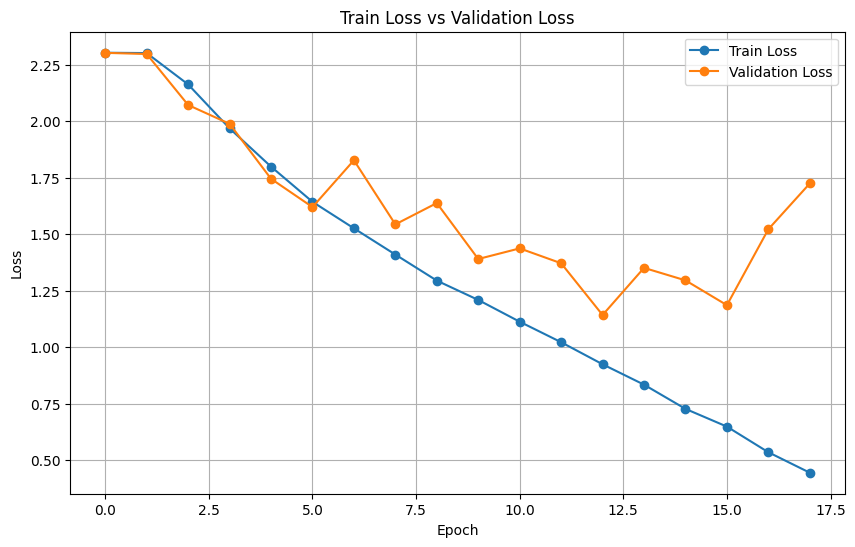

In [ ]:
# Plot train loss and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')

# Add labels and a legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Display the plot
plt.grid()
plt.title('Train Loss vs Validation Loss')
plt.show()







## **Testing-**

In [ ]:
total_test_loss = 0

#model.load_state_dict(torch.load('model.dth'))
model.load_state_dict(torch.load('/content/model.dth'))
model.eval()
total_val = 0
correct_val = 0
for itr, (image, label) in enumerate(test_dataloader):

    if (torch.cuda.is_available()):
        image = image.cuda()
        label = label.cuda()

    pred = model(image)

    loss = criterion(pred, label)
    #total_test_loss += loss.item()

    predicted = torch.argmax(pred, 1)
    total_val += label.shape[0]
    correct_val += (predicted == label).sum().item()

accuracy = (100 * correct_val) / total_val
#val_accuracy.append(accuracy)

#total_test_loss = total_test_loss / (itr + 1)
#test_loss.append(total_test_loss)
print('\n Test Accuracy: {:.8f}'.format(accuracy))


 Test Accuracy: 61.70000000


#  Visualizing Filters of the First and Last Convolutional Layers after Training

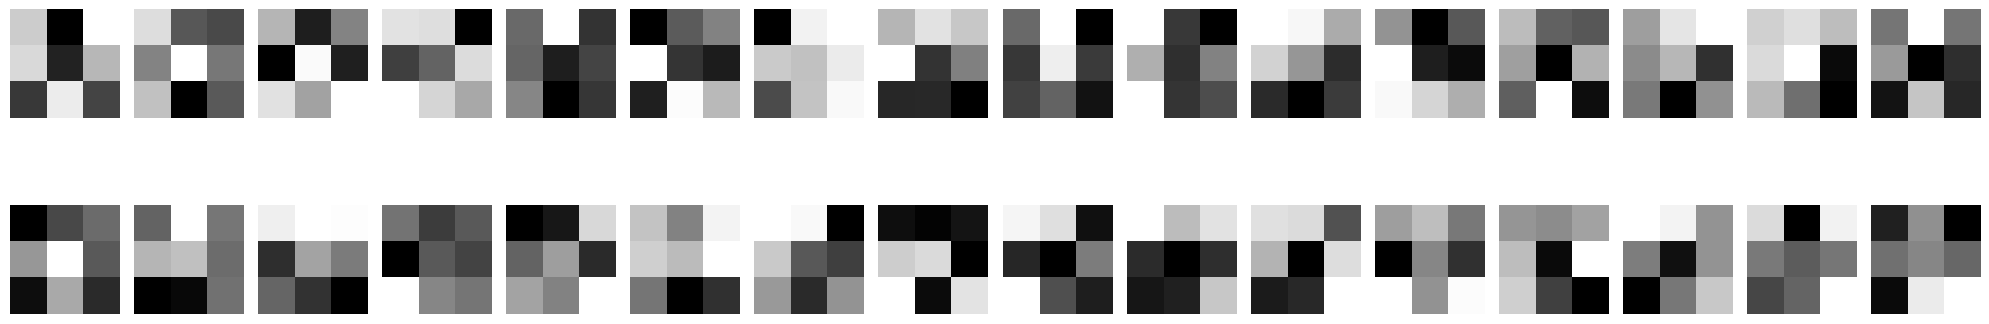

In [ ]:
set_random_seed(42)
def visualize_filters(model):
    first_conv_weights = model.conv1.weight.data.cpu().numpy()  # shape: (64, 3, 3, 3)
    last_conv_weights = model.conv11.weight.data.cpu().numpy()  # shape: (512, 512, 3, 3)

    first_conv_weights = (first_conv_weights - first_conv_weights.min()) / (first_conv_weights.max() - first_conv_weights.min())

    last_conv_weights = (last_conv_weights - last_conv_weights.min()) / (last_conv_weights.max() - last_conv_weights.min())

    # Set up the figure
    fig, axes = plt.subplots(2, 16, figsize=(20, 5))

    for i in range(16):
        axes[0, i].imshow(first_conv_weights[i, 0], cmap='gray')
        axes[0, i].axis('off')
    axes[0, 0].set_ylabel('First Layer Filters')

    for i in range(16):
        axes[1, i].imshow(last_conv_weights[i, 0], cmap='gray')
        axes[1, i].axis('off')
    axes[1, 0].set_ylabel('Last Layer Filters')

    plt.tight_layout()
    plt.show()

visualize_filters(model)


$\Large\textbf{Visualizing the Convolution Feature Maps After Training}$

Registered activation hooks for first and last convolutional layers (conv1, conv11)
Visualizing feature maps for Image 13 in layer 'conv1'


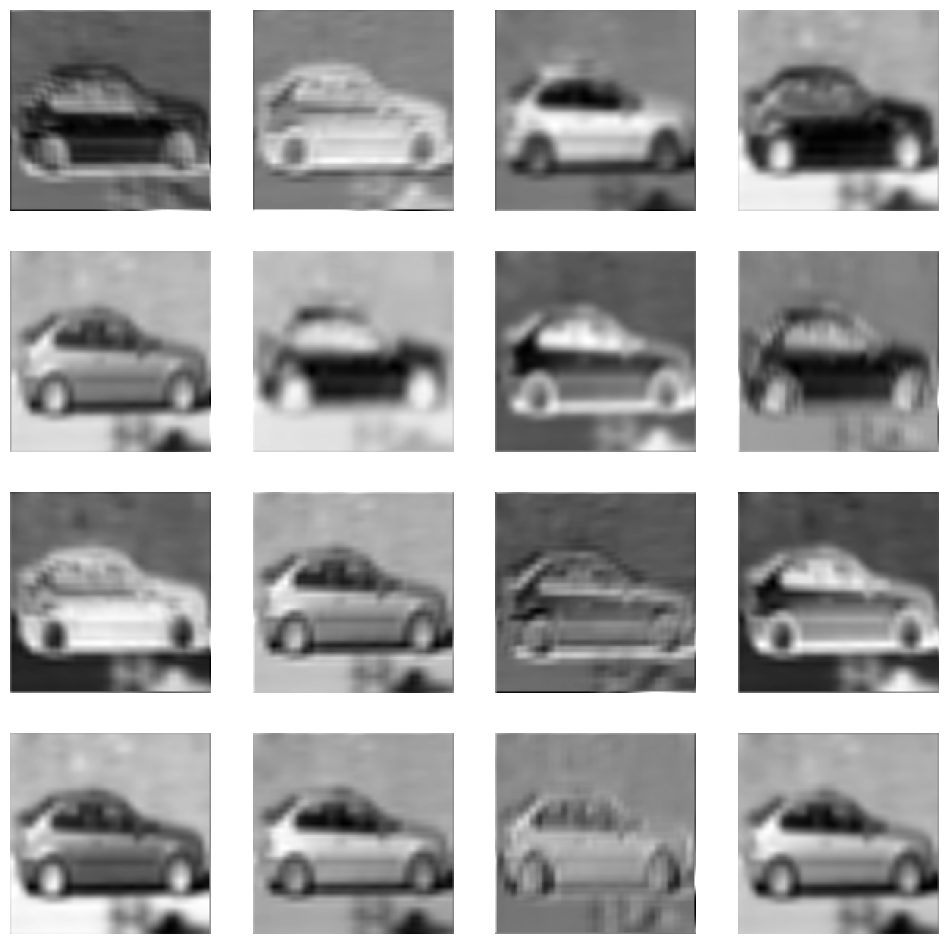

Visualizing feature maps for Image 13 in layer 'conv11'


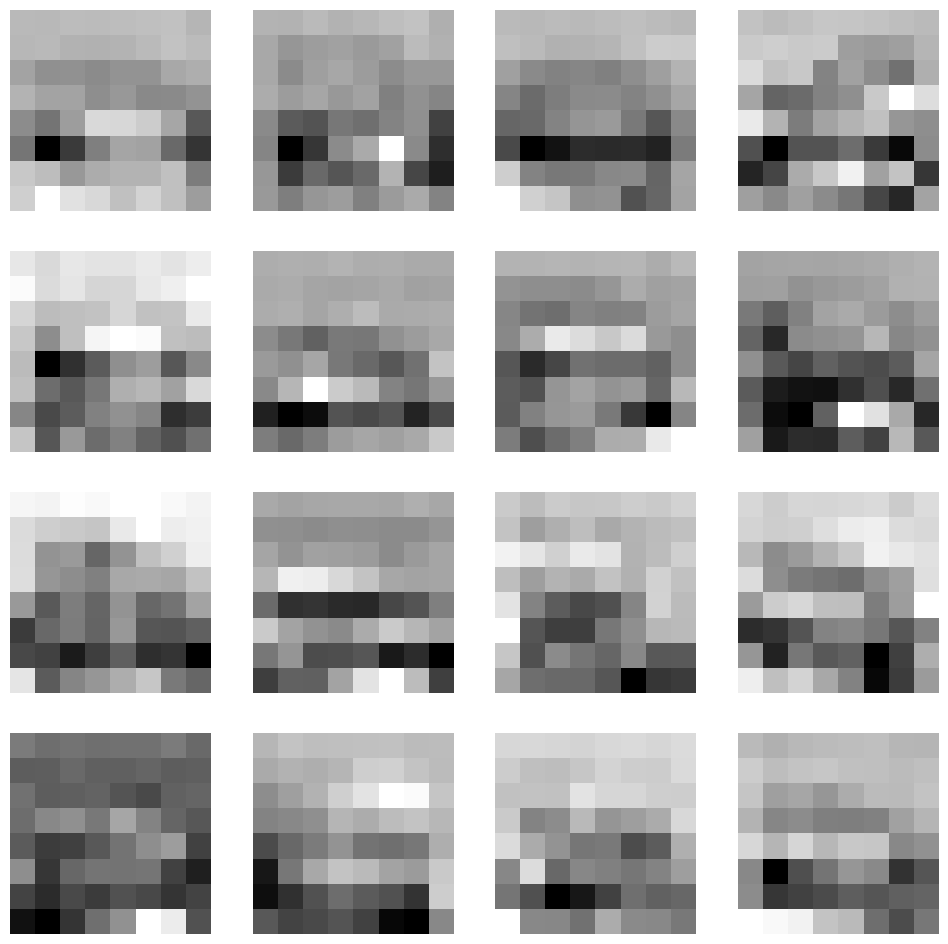

In [ ]:
# Load the trained model
model.load_state_dict(torch.load('model.dth'))
model.eval()
set_random_seed(42)
# Dictionary to store activations for different layers
activation = {}

# Hook function to store activations
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Register hooks for the first and last convolutional layers only
model.conv1.register_forward_hook(get_activation('conv1'))
model.conv11.register_forward_hook(get_activation('conv11'))

print("Registered activation hooks for first and last convolutional layers (conv1, conv11)")

def visualize_feature_maps(activation, layer_name, image_idx, num_feature_maps=16):
    feature_maps = activation[layer_name].cpu().numpy()  # (batch_size, num_filters, height, width)
    batch_size, num_filters, height, width = feature_maps.shape

    selected_filters = random.sample(range(num_filters), min(num_feature_maps, num_filters))

    # Set the layout for visualizing feature maps
    num_cols = 4
    num_rows = 4

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))
    for i, filter_idx in enumerate(selected_filters):
        feature_map = feature_maps[image_idx, filter_idx, :, :]
        row, col = divmod(i, num_cols)
        axes[row, col].imshow(feature_map, cmap='gray')
        axes[row, col].axis('off')

    plt.show()

for images, _ in train_dataloader:
    # Forward pass to generate feature maps
    images = images.to(device)
    output = model(images)

    image_idx = 12  # For image 13

    # Visualize feature maps for the first layer (conv1)
    print(f"Visualizing feature maps for Image {image_idx + 1} in layer 'conv1'")
    visualize_feature_maps(activation, 'conv1', image_idx=image_idx)

    # Visualize feature maps for the last layer (conv11)
    print(f"Visualizing feature maps for Image {image_idx + 1} in layer 'conv11'")
    visualize_feature_maps(activation, 'conv11', image_idx=image_idx)

    break

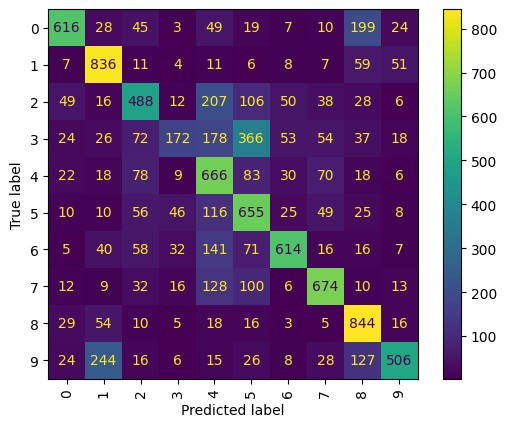

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Initialize variables to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Set the model to evaluation mode
model.eval()

# Iterate through the test dataloader to make predictions and collect labels
for itr, (image, label) in enumerate(test_dataloader):
    if (torch.cuda.is_available()):
        image = image.cuda()
        label = label.cuda()

    pred = model(image)
    predicted = torch.argmax(pred, 1)

    true_labels.extend(label.cpu().numpy())
    predicted_labels.extend(predicted.cpu().numpy())

# Create a confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion)
disp.plot(cmap='viridis', xticks_rotation='vertical')
plt.show()


Exercises:

1. Modify Model Depth: In the VGG16 class definition (__init__ and forward methods), uncomment the second convolutional layer in Block 1 (self.conv2) and the third convolutional layer in Block 3 (self.conv7).

2. What is the trade-off between model complexity (more layers) and computational cost (training time)?

3. Try to reduce the overfitting of this model by trying different training strategies and mechanisms.

